In [ ]:
#importing the networkx library
import networkx as nx
import random
import numpy as np
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_optimization.applications import Maxcut
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B

m = 3  # layers
A = np.zeros([m+2,100])
B = np.zeros([m+2,100])

for ii in range(100):
    A[0][ii] = ii+1
    B[0][ii] = ii+1
    n = 10  # nodes
    G= nx.erdos_renyi_graph(n,0.5)

    for (u, v) in G.edges():
        G[u][v]['weight'] = random.uniform(1.0, 1.0)

    w = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i,j,default=0)
            if temp != 0:
                w[i][j] = temp["weight"]

    quadratic_program = Maxcut(w).to_quadratic_program()


    sampler = Sampler()

    # Gradient free optimizer method program
    optimizer = COBYLA()  # Gradient free optimizer
    # Use QAOA
    for jj in range(m):
        qaoa = QAOA(sampler, optimizer, reps=jj+1)  # Using 1,2,...,m layers

        # Get the operator and offset
        op, offset = quadratic_program.to_ising()

        # Run the QAOA algorithm
        qaoa_result = qaoa.compute_minimum_eigenvalue(op)
        eigenstate = qaoa_result.eigenstate

        # Extract the most likely state
        sorted_counts = sorted(eigenstate.items(), key=lambda x: x[1], reverse=True)
        most_likely_state = sorted_counts[0][0]  # Get the bitstring with the highest probability
        #print("Most likely state (bitstring):", most_likely_state)

        # Convert the bitstring into a binary array
        solution = np.array([int(bit) for bit in reversed(list(bin(most_likely_state)[2:].zfill(n)))])

        # Print the solution
        cut_edges = [(i, j) for i, j in G.edges if solution[i] != solution[j]]

        A[jj+1][ii] = len(cut_edges)

    #Gradient based optimizer method program
    optimizer = L_BFGS_B()  # Gradient based optimizer
    # Use QAOA
    for jj in range(0,m,1):
        qaoa = QAOA(sampler, optimizer, reps=jj+1)  # Using 1,2,...,m layers

        # Get the operator and offset
        op, offset = quadratic_program.to_ising()

        # Run the QAOA algorithm
        qaoa_result = qaoa.compute_minimum_eigenvalue(op)
        eigenstate = qaoa_result.eigenstate

        # Extract the most likely state
        sorted_counts = sorted(eigenstate.items(), key=lambda x: x[1], reverse=True)
        most_likely_state = sorted_counts[0][0]  # Get the bitstring with the highest probability
        #print("Most likely state (bitstring):", most_likely_state)

        # Convert the bitstring into a binary array
        solution = np.array([int(bit) for bit in reversed(list(bin(most_likely_state)[2:].zfill(n)))])

        # Print the solution
        cut_edges = [(k, l) for k, l in G.edges if solution[k] != solution[l]]

        B[jj+1][ii] = len(cut_edges)



    #classical program
    sol = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        Cut_value = 0
        for i in range(n):
            for j in range(n):
                Cut_value += w[i][j]*x[i]*(1-x[j])
        if sol < Cut_value:
            sol = Cut_value
            xlist = x
    
    A[m+1][ii] = int(sol)
    B[m+1][ii] = int(sol)

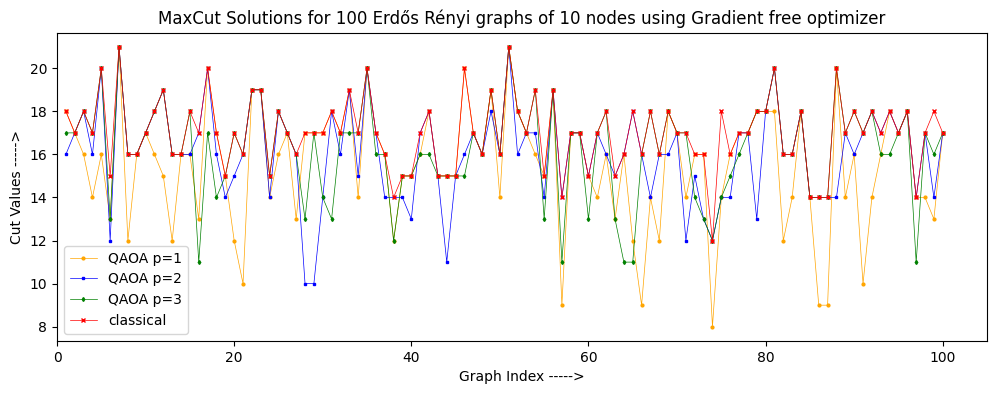

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))  # Width: 12 inches, Height: 4 inches
plt.xlim(0,105)
plt.plot(A[0], A[1], label='QAOA p=1', marker='o', markersize=2, linewidth=0.5, color='orange') 
plt.plot(A[0], A[2], label='QAOA p=2', marker='s', markersize=2, linewidth=0.5, color='blue') 
plt.plot(A[0], A[3], label='QAOA p=3', marker='d', markersize=2, linewidth=0.5, color='green') 
plt.plot(A[0], A[4], label='classical', marker='x', markersize=3, linewidth=0.5, color='red') 

#plt.grid()
plt.xlabel("Graph Index ----->")
plt.ylabel("Cut Values ----->")
plt.title("MaxCut Solutions for 100 Erdős Rényi graphs of 10 nodes using Gradient free optimizer")
plt.legend(loc='best')
plt.savefig('non_grad_100_graphs.png', dpi=600)

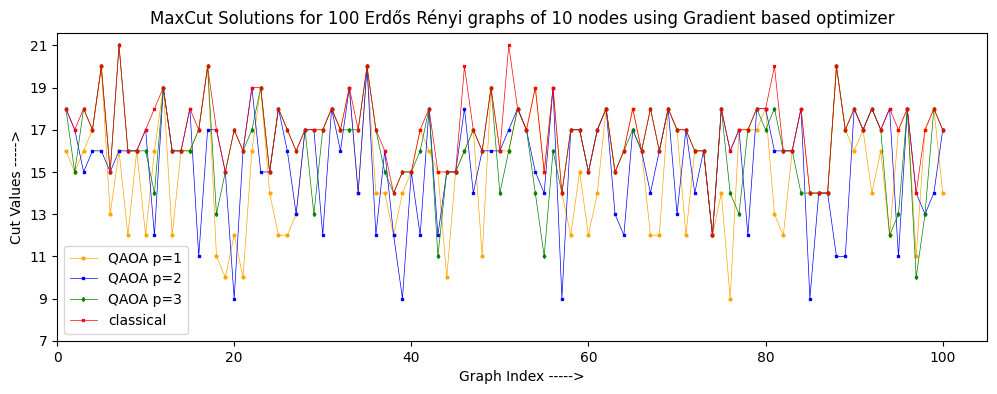

In [37]:
plt.figure(figsize=(12, 4))  # Width: 12 inches, Height: 6 inches
plt.xlim(0,105)
plt.plot(B[0], B[1], label='QAOA p=1', marker='o', markersize=2, linewidth=0.5, color='orange') 
plt.plot(B[0], B[2], label='QAOA p=2', marker='s', markersize=2, linewidth=0.5, color='blue')  
plt.plot(B[0], B[3], label='QAOA p=3', marker='d', markersize=2, linewidth=0.5, color='green') 
plt.plot(B[0], B[4], label='classical', marker='x', markersize=2, linewidth=0.5, color='red')

#plt.grid()
plt.xlabel("Graph Index ----->")
plt.ylabel("Cut Values ----->")
plt.title("MaxCut Solutions for 100 Erdős Rényi graphs of 10 nodes using Gradient based optimizer")
plt.legend(loc='best')
plt.yticks(np.arange(7, 22, 2))
#plt.tight_layout()
plt.savefig('grad_100_graphs.png', dpi=600)

Gradient free normalized maxcut values w.r.t. classical method:  [0.9113853506314807, 0.9465844513243892, 0.9524822657133027]
Gradient based normalized maxcut values w.r.t. classical method:  [0.8989774251805983, 0.9096695599292346, 0.9528701348960636]


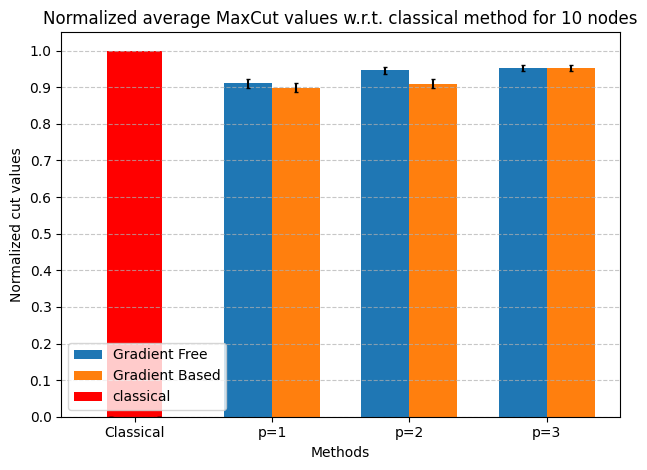

In [28]:
C = [0.]
D= [0.]
CC = np.zeros([3,100])
DD = np.zeros([3,100])
C_err =[0.]
D_err = [0.]
for j in range(0,3,1):
    s = 0
    s1 = 0
    for i in range(0,100,1):
        ss = A[j+1][i]/A[4][i]
        s += ss
        ss1 = B[j+1][i]/B[4][i]
        s1 += ss1
        CC[j][i] = ss
        DD[j][i] = ss1
    s = s/100
    s1 = s1/100
    C.append(float(s)) 
    D.append(float(s1))
    mean = np.mean(CC[j])
    std_dev = np.std(CC[j], ddof=1)
    sem = std_dev/np.sqrt(len(CC[j]))
    C_err.append(float(sem))
    mean1 = np.mean(DD[j])
    std_dev1 = np.std(DD[j], ddof=1)
    sem1 = std_dev1/np.sqrt(len(DD[j]))
    D_err.append(float(sem1))


print('Gradient free normalized maxcut values w.r.t. classical method: ',C[1:])
print('Gradient based normalized maxcut values w.r.t. classical method: ',D[1:])
E = ['Classical','p=1','p=2','p=3']
bar_width = 0.35  # Width of each bar
x_indices = np.arange(len(E))  # Indices for groups
cl = [1.0, 0.0, 0.0, 0.0]  # for classical method
# Create bars for each series
plt.bar(x_indices - bar_width/2, C, bar_width,yerr=C_err,capsize=1.5, label='Gradient Free')  # First series
plt.bar(x_indices + bar_width/2, D, bar_width,yerr=D_err,capsize=1.5, label='Gradient Based')  # Second series
plt.bar(x_indices,cl,width=0.4,color='red',label='classical')

plt.title('Normalized average MaxCut values w.r.t. classical method for 10 nodes')
plt.xlabel("Methods")
plt.ylabel("Normalized cut values")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(x_indices, E)  # Set x-axis tick labels to `x`
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower left', fontsize=10)
plt.tight_layout()
plt.savefig('Normalized_bar_plot.png', dpi=600)

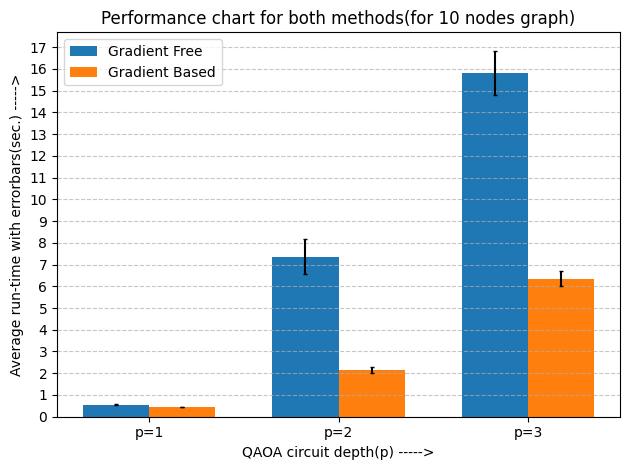

In [36]:
import numpy as np
import matplotlib.pyplot as plt
A1 = [0.7,0.6,0.6,0.6,0.6,0.7,0.5,0.6,0.5,0.5,0.8,0.4,0.4,0.5,0.6,0.5,0.5,0.6,0.7,0.5,0.4,0.5,0.5,0.5,0.5,0.6,0.5,0.5,0.5,0.5,0.6]
A2 = [4.9,1.2,6.1,3.1,10.1,1.1,2.5,16.4,17.3,9.8,2.3,2.3,18.2,4.8,5.4,7.6,17.6,5.2,6.1,3.8,5.9,11.3,4.9,4.9,13.5,2.4,4.4,17.7,1.5,5.3,1.6,14.6,16.9,3.1,8.2,5.7,3.5,1.3,1.5,18.0,9.5,2.5,16.9,7.0,4.5,10.6,2.7]
A3 = [5.6,15.2,19.7,19.9,4.5,20.8,17.1,19.9,19.6,15.8,20.1,13.7,8.5,20.5,20.8,20.3,17.3,19.8,20.8,16.0,9.0,20.9,20.8,16.0,9.0,20.9,20.8,4.0,20.7,21.0,3.3,17.6,20.5,4.5,8.4]


B1 = [0.7, 0.3, 0.8, 0.9, 0.5, 0.9, 0.4, 0.8, 0.6, 0.7, 1.0, 0.4, 0.5, 0.3, 0.3, 0.4, 0.3, 0.5, 0.4, 0.6, 0.5, 0.4, 0.3, 0.4, 0.5, 0.4, 0.6, 0.4, 0.5, 0.3, 0.5, 0.4, 0.5, 0.6, 0.4, 0.3, 0.5, 0.3, 0.7, 0.6, 0.3, 0.4, 0.6, 0.5, 0.3, 0.5, 0.4, 0.3, 0.4, 0.4, 0.3, 0.2, 0.6, 0.3, 0.3, 0.4, 0.4, 0.4, 0.3, 0.3, 0.4, 0.5, 0.4, 0.4,
    0.5, 0.6, 0.4, 0.3, 0.5, 0.3, 0.7, 0.6, 0.3, 0.4, 0.6, 0.5, 0.3, 0.5, 0.4, 0.3, 0.4, 0.4, 0.3, 0.2, 0.6, 0.3, 0.3, 0.4, 0.4, 0.4, 0.3, 0.3, 0.4, 0.5, 0.4, 0.4]
B2 = [1.9, 2.4, 1.4, 3.0, 2.6, 3.5, 1.7, 2.1, 2.1, 1.4, 1.6, 2.2, 1.3, 1.6, 1.5, 2.3, 1.8, 2.3, 1.7, 3.5, 2.0, 1.3, 2.6, 3.3, 3.5, 1.6, 3.8, 1.8, 1.4, 1.6, 2.3 ]
B3 = [4.9, 5.7, 5.0, 9.7, 7.4, 5.8, 4.4, 2.4, 5.4, 6.3, 6.2, 6.2, 7.8, 4.8, 9.8, 6.7, 9.3, 8.4, 5.7, 8.3, 3.9, 6.7, 5.9, 6.9, 8.0, 3.1, 5.1, 3.5, 9.1, 9.5, 5.1]


AA = np.zeros([3,6])
def f(A1):
    mean = np.mean(A1)
    std_dev = np.std(A1, ddof=1)
    sem = std_dev/np.sqrt(len(A1))
    BB = np.zeros(3)
    BB[0] = (float(mean))
    BB[1] = (float(std_dev))
    BB[2] = (float(sem))
    return BB

for j in range(0,3,1):
    AA[j][0] = f(A1)[j]
    AA[j][1] = f(A2)[j]
    AA[j][2] = f(A3)[j]
    AA[j][3] = f(B1)[j]
    AA[j][4] = f(B2)[j]
    AA[j][5] = f(B3)[j]

x = np.array(["p=1", "p=2", "p=3"])  # X-axis positions
vals = [AA[0][:3],AA[0][-3:]]
y_err = [AA[2][:3],AA[2][-3:]]

bar_width = 0.35  # Width of each bar
x_indices = np.arange(len(x))  # Indices for groups

# Create bars for each series
plt.bar(x_indices - bar_width/2, vals[0], bar_width,yerr=y_err[0],capsize=1.5, label='Gradient Free')  # First series
plt.bar(x_indices + bar_width/2, vals[1], bar_width,yerr=y_err[1],capsize=1.5, label='Gradient Based')  # Second series

# Add labels, title, and legend
plt.xlabel('QAOA circuit depth(p) ----->')
plt.ylabel('Average run-time with errorbars(sec.) ----->')
plt.title('Performance chart for both methods(for 10 nodes graph)')
plt.xticks(x_indices, x)  # Set x-axis tick labels to `x`
plt.yticks(np.arange(0, 18, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('performance_bar_plot_10_nodes.png', dpi=600)

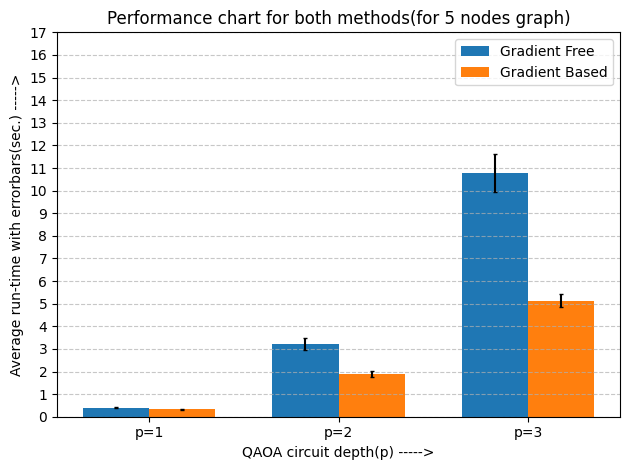

In [35]:
import numpy as np
import matplotlib.pyplot as plt

A1 = [0.3, 0.5, 0.6, 0.4, 0.3, 0.4, 0.3, 0.3, 0.6, 0.5, 0.3, 0.3, 0.5, 0.4, 0.4, 0.3, 0.4, 0.4, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3]
A2 = [4.6, 0.9, 2.9, 4.9, 2.6, 2.1, 4.7, 4.0, 4.6, 3.7, 3.1, 3.0, 0.8, 2.5, 1.5, 3.8, 3.6, 0.8, 4.3, 1.9, 5.7, 1.7, 4.1, 4.4, 5.0, 1.8, 4.0, 1.7, 5.2, 2.0, 3.5]
A3 = [5.4, 3.9, 11.5, 19.9, 8.3, 3.0, 11.7, 10.1, 12.1, 15.9, 12.9, 8.6, 11.9, 14.3, 19.0, 3.2, 9.3, 6.0, 16.5, 15.0, 10.2, 10.5, 15.6, 1.5, 14.8, 12.0, 12.2, 11.4, 11.6, 10.8, 5.2]
B1 = [0.5, 0.5, 0.4, 0.2, 0.2, 0.3, 0.4, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.2, 0.5, 0.3, 0.6, 0.3, 0.2, 0.2, 0.2, 0.5, 0.3, 0.3, 0.3, 0.3, 0.2, 0.5, 0.3, 0.2]
B2 = [2.2, 2.2, 2.1, 0.9, 2.2, 1.4, 2.3, 2.1, 2.7, 0.9, 1.3, 0.9, 1.0, 2.2, 1.8, 1.0, 1.5, 1.9, 3.2, 1.3, 1.6, 1.9, 4.2, 1.7, 2.0, 1.6, 2.1, 2.7, 1.4, 2.9, 1.4]
B3 = [3.1, 7.3, 5.5, 4.8, 6.0, 6.7, 7.3, 7.7, 4.9, 4.6, 2.2, 6.1, 4.2, 4.2, 3.2, 3.9, 4.2, 2.8, 7.6, 7.8, 7.1, 4.8, 5.4, 3.4, 4.7, 6.1, 3.8, 6.4, 4.0, 5.3, 4.2]


AA = np.zeros([3,6])
def f(A1):
    mean = np.mean(A1)
    std_dev = np.std(A1, ddof=1)
    sem = std_dev/np.sqrt(len(A1))
    BB = np.zeros(3)
    BB[0] = (float(mean))
    BB[1] = (float(std_dev))
    BB[2] = (float(sem))
    return BB

for j in range(0,3,1):
    AA[j][0] = f(A1)[j]
    AA[j][1] = f(A2)[j]
    AA[j][2] = f(A3)[j]
    AA[j][3] = f(B1)[j]
    AA[j][4] = f(B2)[j]
    AA[j][5] = f(B3)[j]

x = np.array(["p=1", "p=2", "p=3"])  # X-axis positions
vals = [AA[0][:3],AA[0][-3:]]
y_err = [AA[2][:3],AA[2][-3:]]

bar_width = 0.35  # Width of each bar
x_indices = np.arange(len(x))  # Indices for groups

# Create bars for each series
plt.bar(x_indices - bar_width/2, vals[0], bar_width,yerr=y_err[0],capsize=1.5, label='Gradient Free')  # First series
plt.bar(x_indices + bar_width/2, vals[1], bar_width,yerr=y_err[1],capsize=1.5, label='Gradient Based')  # Second series

# Add labels, title, and legend
plt.xlabel('QAOA circuit depth(p) ----->')
plt.ylabel('Average run-time with errorbars(sec.) ----->')
plt.title('Performance chart for both methods(for 5 nodes graph)')
plt.xticks(x_indices, x)  # Set x-axis tick labels to `x`
plt.yticks(np.arange(0, 18, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('performance_bar_plot_5_nodes.png', dpi=600)
